# Assignment 5: Block Matching and Harris Corner Detection
## Ex. 5.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

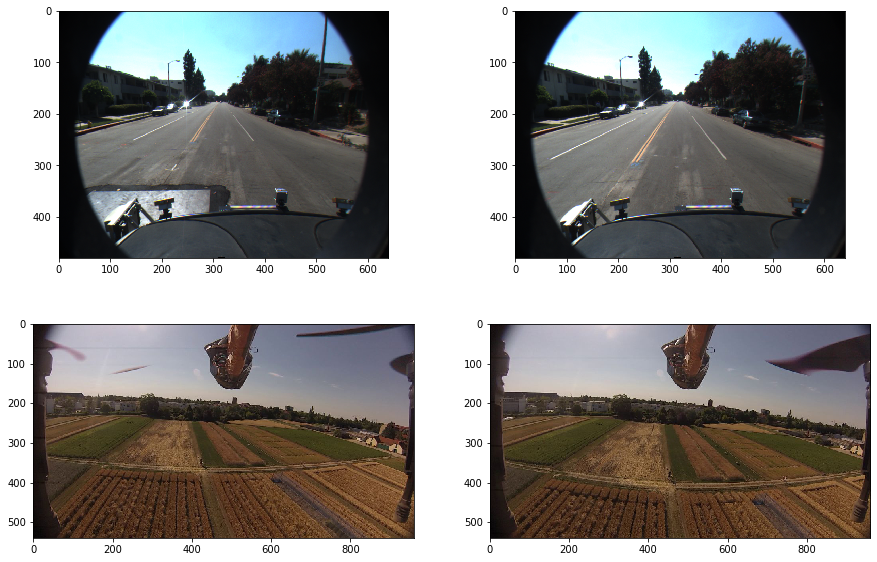

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

# Chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

# Footage from our Neurocopter project:
# http://berlinbiorobotics.blog/projects/neurocopter/
copter1 = io.imread('images/copter_flight/frame050.jpg')
copter2 = io.imread('images/copter_flight/frame052.jpg') 

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(copter1)
ax22.imshow(copter2)

In [108]:
from skimage import io, data, feature, color
import numpy as np


def get_window_coords(x, y, window_size, shape=None, clip=None, as_tuple=False):
    """
    :param window_size: (height, width) values should be odd
    
    Returned values are exclusive so ready for slicing.
    """
    
    delta_y, delta_x = window_size // 2
    if clip:
        clip_y, clip_x = clip
    else:
        assert shape, "'shape' argument required, when 'clip' is not given"
        height, width = shape
        clip_y = (0, height)
        clip_x = (0, width)
    y_min, y_max = np.clip(np.array([y - delta_y, y + delta_y + 1]), *clip_y)
    x_min, x_max = np.clip(np.array([x - delta_x, x + delta_x + 1]), *clip_x)
    if as_tuple:
        # No 'step' value here...
        return ((y_min, y_max), (x_min, x_max))
    return np.s_[y_min:y_max, x_min:x_max]
    

def get_window(image, x, y, window_size, shape):
    return image[get_window_coords(x, y, window_size, shape)]


def calc_ssd(image, x, y, dx, dy, block, shape):
    ty, tx = y + dy, x + dx
    shifted_block = get_window(image, tx, ty, BLOCK_SIZE, shape)
    return np.sum(np.square(block - shifted_block))


def calc_flow(image, x, y, block, shape):
    flow_vector = None
    min_ssd = None
    ref = np.array([x, y])
    
    height, width = shape
    pad_y, pad_x = block_size // 2
    clip = ((pad_y, height - pad_y), (pad_x, width - pad_x))
    (y_min, y_max), (x_min, x_max) = get_window_coords(
        x, y, 
        SEARCH_WINDOW_SIZE, 
        clip=clip, 
        as_tuple=True,
    )
    for yi in range(y_min, y_max):
        for xi in range(x_min, x_max):
            dx, dy = np.array([xi, yi]) - ref
            ssd = calc_ssd(image, x, y, dx, dy, block, shape)
            if min_ssd is None or ssd < min_ssd:
                min_ssd = ssd
                flow_vector = np.array([dx, dy])
    return flow_vector


store = {}
BLOCK_SIZE = np.array([11, 11])
SEARCH_WINDOW_SIZE = np.array([71, 71])
sequence = [color.rgb2gray(image) for image in [lane1, lane2]]
shape = sequence[0].shape
print(shape)
for t, image in enumerate(sequence[1:], start=1):
    for x, y in [
        [424, 198],
        [230, 97],
        [313, 259],
        # Street sign...not working so well.
        # [496, 153],
    ]:
        print(f'at x={x}, y={y}. finding flow vector...')
        block = get_window(sequence[t - 1], x, y, BLOCK_SIZE, shape)
        search_window = get_window(image, x, y, SEARCH_WINDOW_SIZE, shape)
        flow_vector = calc_flow(image, x, y, block, shape)
        store[(x, y)] = flow_vector

print(store)
None

(480, 640)
at x=424, y=198. finding flow vector...
at x=230, y=97. finding flow vector...
at x=313, y=259. finding flow vector...
{(424, 198): array([27,  0]), (230, 97): array([-7, -8]), (313, 259): array([ 2, 26])}


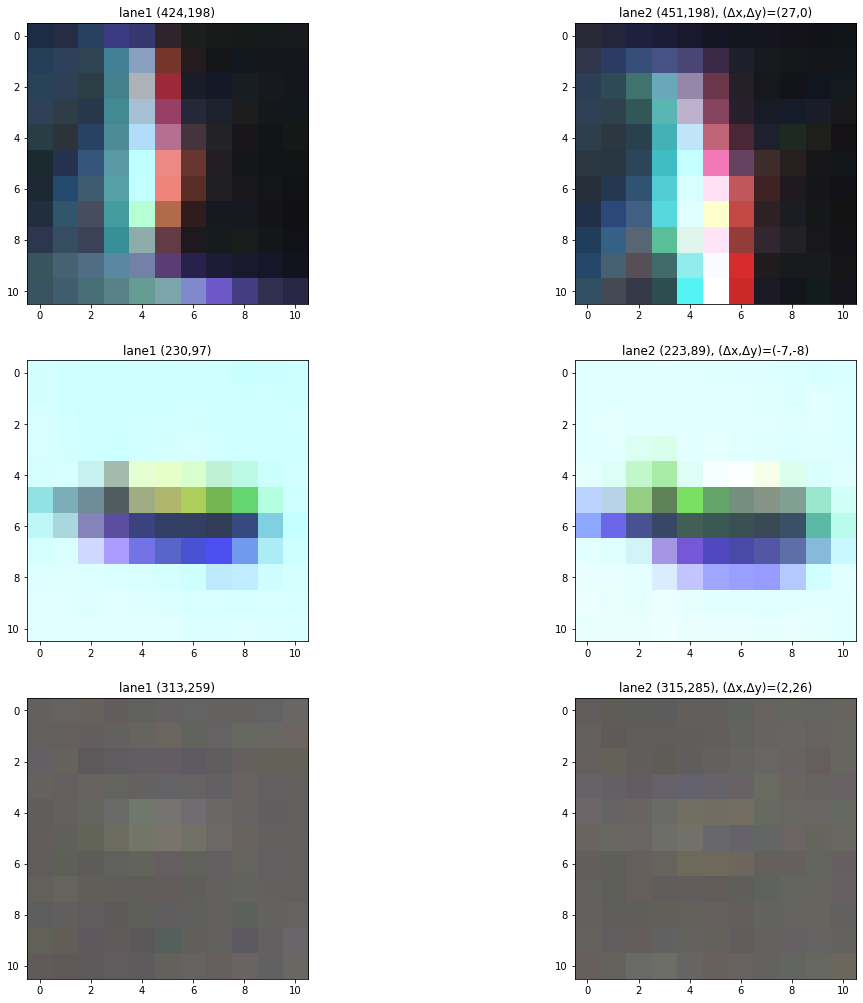

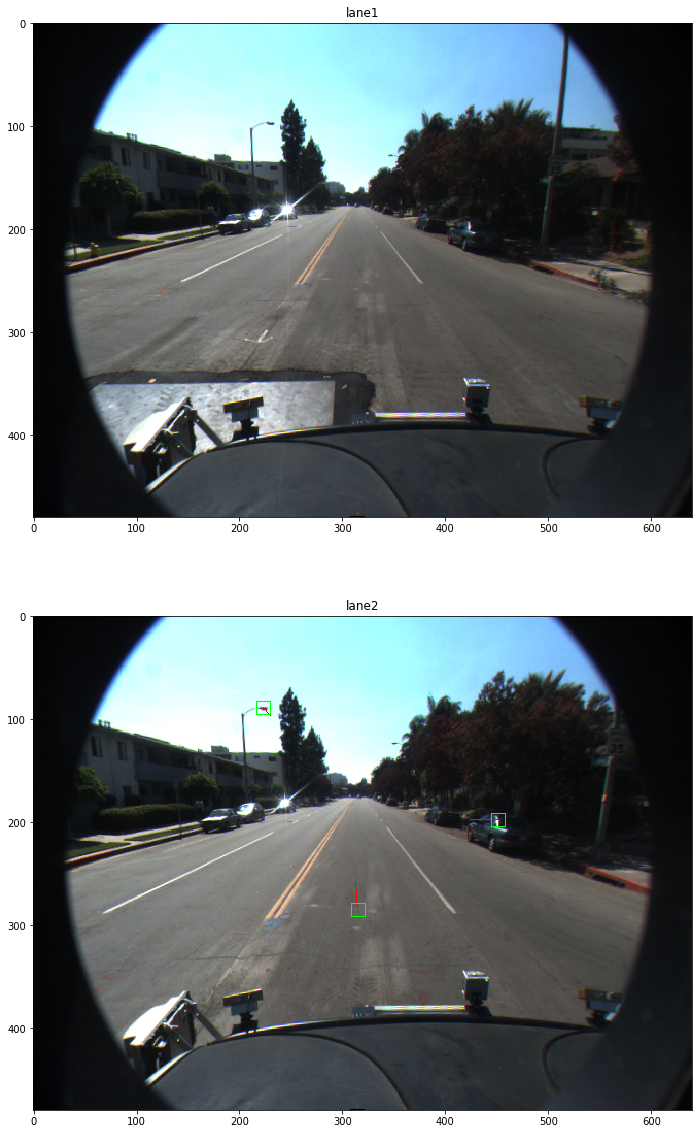

In [109]:
from skimage.draw import line, rectangle_perimeter as rect


N = len(store)
fig = plt.figure(figsize=(18, 10*N), dpi=72)
fig.tight_layout()
grid = fig.add_gridspec(N + 2, 2)

res_img = np.copy(lane2)
for i, ((x, y), (dx, dy)) in enumerate(store.items()):
    rr, cc = line(y, x, y + dy, x + dx)
    res_img[rr, cc] = np.array([255, 0, 0])
    (y_min, y_max), (x_min, x_max) = get_window_coords(x + dx, y + dy, BLOCK_SIZE, shape, as_tuple=True)
    rr, cc = rect((y_min, x_min), (y_max, x_max), shape=shape)
    res_img[rr, cc] = np.array([0, 255, 0])
    
    ax1 = fig.add_subplot(grid[i, 0])
    ax2 = fig.add_subplot(grid[i, 1])

    ax1.imshow(get_window(lane1, x, y, block_size, shape))
    ax1.set_title(f'lane1 ({x},{y})')
    ax2.imshow(get_window(lane2, x + dx, y + dy, block_size, shape))
    ax2.set_title(f'lane2 ({x + dx},{y + dy}), (Δx,Δy)=({dx},{dy})')


fig = plt.figure(figsize=(18, 20), dpi=72)
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)
ax1.set_title(f'lane1')
ax1.imshow(lane1)
ax2.set_title(f'lane2')
ax2.imshow(res_img)

plt.show()
None

at x=5, y=5. finding flow vector...
at x=5, y=27. finding flow vector...
at x=5, y=49. finding flow vector...
at x=5, y=71. finding flow vector...
at x=5, y=93. finding flow vector...
at x=5, y=115. finding flow vector...
at x=5, y=137. finding flow vector...
at x=5, y=159. finding flow vector...
at x=5, y=181. finding flow vector...
at x=5, y=203. finding flow vector...
at x=5, y=225. finding flow vector...
at x=5, y=247. finding flow vector...
at x=5, y=269. finding flow vector...
at x=5, y=291. finding flow vector...
at x=5, y=313. finding flow vector...
at x=5, y=335. finding flow vector...
at x=5, y=357. finding flow vector...
at x=5, y=379. finding flow vector...
at x=5, y=401. finding flow vector...
at x=5, y=423. finding flow vector...
at x=5, y=445. finding flow vector...
at x=5, y=467. finding flow vector...
at x=27, y=5. finding flow vector...
at x=27, y=27. finding flow vector...
at x=27, y=49. finding flow vector...
at x=27, y=71. finding flow vector...
at x=27, y=93. find

at x=203, y=269. finding flow vector...
at x=203, y=291. finding flow vector...
at x=203, y=313. finding flow vector...
at x=203, y=335. finding flow vector...
at x=203, y=357. finding flow vector...
at x=203, y=379. finding flow vector...
at x=203, y=401. finding flow vector...
at x=203, y=423. finding flow vector...
at x=203, y=445. finding flow vector...
at x=203, y=467. finding flow vector...
at x=225, y=5. finding flow vector...
at x=225, y=27. finding flow vector...
at x=225, y=49. finding flow vector...
at x=225, y=71. finding flow vector...
at x=225, y=93. finding flow vector...
at x=225, y=115. finding flow vector...
at x=225, y=137. finding flow vector...
at x=225, y=159. finding flow vector...
at x=225, y=181. finding flow vector...
at x=225, y=203. finding flow vector...
at x=225, y=225. finding flow vector...
at x=225, y=247. finding flow vector...
at x=225, y=269. finding flow vector...
at x=225, y=291. finding flow vector...
at x=225, y=313. finding flow vector...
at x=2

at x=401, y=467. finding flow vector...
at x=423, y=5. finding flow vector...
at x=423, y=27. finding flow vector...
at x=423, y=49. finding flow vector...
at x=423, y=71. finding flow vector...
at x=423, y=93. finding flow vector...
at x=423, y=115. finding flow vector...
at x=423, y=137. finding flow vector...
at x=423, y=159. finding flow vector...
at x=423, y=181. finding flow vector...
at x=423, y=203. finding flow vector...
at x=423, y=225. finding flow vector...
at x=423, y=247. finding flow vector...
at x=423, y=269. finding flow vector...
at x=423, y=291. finding flow vector...
at x=423, y=313. finding flow vector...
at x=423, y=335. finding flow vector...
at x=423, y=357. finding flow vector...
at x=423, y=379. finding flow vector...
at x=423, y=401. finding flow vector...
at x=423, y=423. finding flow vector...
at x=423, y=445. finding flow vector...
at x=423, y=467. finding flow vector...
at x=445, y=5. finding flow vector...
at x=445, y=27. finding flow vector...
at x=445,

at x=621, y=203. finding flow vector...
at x=621, y=225. finding flow vector...
at x=621, y=247. finding flow vector...
at x=621, y=269. finding flow vector...
at x=621, y=291. finding flow vector...
at x=621, y=313. finding flow vector...
at x=621, y=335. finding flow vector...
at x=621, y=357. finding flow vector...
at x=621, y=379. finding flow vector...
at x=621, y=401. finding flow vector...
at x=621, y=423. finding flow vector...
at x=621, y=445. finding flow vector...
at x=621, y=467. finding flow vector...
{(5, 5): array([0, 0]), (5, 27): array([  6, -12]), (5, 49): array([  5, -13]), (5, 71): array([  9, -33]), (5, 93): array([  5, -34]), (5, 115): array([  1, -33]), (5, 137): array([  0, -29]), (5, 159): array([0, 6]), (5, 181): array([  0, -10]), (5, 203): array([  0, -35]), (5, 225): array([ 0, 33]), (5, 247): array([  0, -21]), (5, 269): array([ 2, 24]), (5, 291): array([ 1, 23]), (5, 313): array([0, 1]), (5, 335): array([  1, -19]), (5, 357): array([ 0, 27]), (5, 379): ar

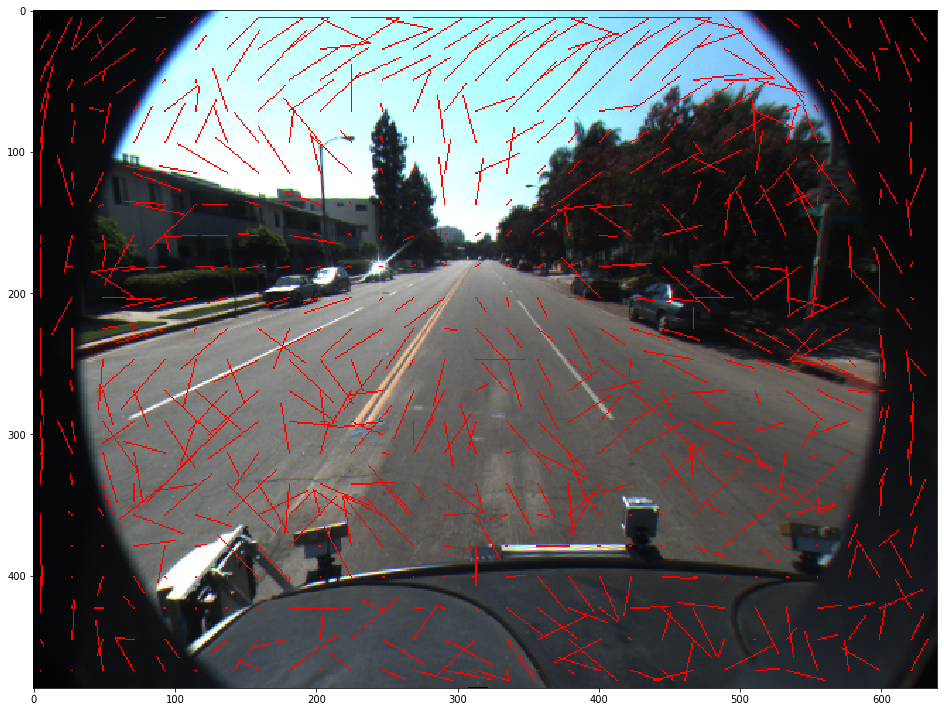

In [112]:
from skimage.draw import line


store_big = {}
STEP_SIZE = BLOCK_SIZE[0] * 2
for t, image in enumerate(sequence[1:], start=1):
    pad_y, pad_x = block_size // 2
    for x in range(pad_x, shape[1] - pad_x, STEP_SIZE):
        for y in range(pad_y, shape[0] - pad_y, STEP_SIZE):
            print(f'at x={x}, y={y}. finding flow vector...')
            block = get_window(sequence[t - 1], x, y, BLOCK_SIZE, shape)
            search_window = get_window(image, x, y, SEARCH_WINDOW_SIZE, shape)
            flow_vector = calc_flow(image, x, y, block, shape)
            store_big[(x, y)] = flow_vector

print(store_big)


fig = plt.figure(figsize=(18, 10), dpi=72)
res_img = np.copy(lane2)
for i, ((x, y), (dx, dy)) in enumerate(store_big.items()):
    rr, cc = line(y, x, y + dy, x + dx)
    res_img[rr, cc] = np.array([255, 0, 0])

io.imshow(res_img)


## Ex. 5.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)